# Library

In [1]:
import torch
import torch.nn as nn
import pandas as pd
from torch.utils.data import DataLoader, Dataset
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import json
import pprint

# Data Exploration

In [2]:
df_train = pd.read_csv("data/review.csv")
df_val = pd.read_csv("data/validation.csv")

In [3]:
df_train

,ReviewerID,ProductID,Text,Summary,Star
0,A1XJXYKOWCH9XT,B000FBFMHU,Liked the movie. Loved the book. It really giv...,Liked the movie. Loved the book!,5.0
1,A1K4S4MWXI9E9M,B000FC27TA,Purchased more out of curiosity than any real ...,"Not my favorite, but...",3.0
2,A3LF914GG87TWP,B000FC27TA,"I actually received this text as an ebook, sin...",An interesting read,4.0
3,A1CNQTCRQ35IMM,B000FCKPG2,REVIEWER'S OPINION:\nThis was labeled as roman...,This was labeled romance but there was less ro...,2.0
4,AU510CVD9XDG,B000GCFWXW,I have been saving the Argeneau novels for awh...,Science Fiction not Paranormal Romance,2.0
...,...,...,...,...,...
52507,A3JVZY05VLMYEM,B01FLJUZ0E,She can't do anything right according to her f...,What Can She Do,5.0
52508,A2U06P692IZOSF,B01FLJUZ0E,Better late than never!!\nKitty Konstantine ha...,BART & KITTY CAT MAKE SPARKS FLY!!,5.0
52509,A3RPL8JIS2XMJ3,B01FLJUZ0E,This book was great. Bartholomew finally gets ...,LOVE THE SAINTS,5.0
52510,A1XMFCMIANCQRW,B01FPYJS1M,I read for a honest review for the author.\nTh...,"Loved Lee and Raina together, Ricky is evil an...",4.0


In [4]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 52512 entries, 0 to 52511
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   ReviewerID  52512 non-null  object 
 1   ProductID   52512 non-null  object 
 2   Text        52512 non-null  object 
 3   Summary     52507 non-null  object 
 4   Star        52512 non-null  float64
dtypes: float64(1), object(4)
memory usage: 2.0+ MB


In [5]:
df_train.isnull().sum()

ReviewerID    0
ProductID     0
Text          0
Summary       5
Star          0
dtype: int64

In [6]:
print("The number of reviewers: ", len(df_train['ReviewerID'].unique()))
print("The number of products: ", len(df_train['ProductID'].unique()))


The number of reviewers:  2752
The number of products:  6336


In [7]:
df_val.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6596 entries, 0 to 6595
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   ReviewerID  6596 non-null   object 
 1   ProductID   6596 non-null   object 
 2   Star        6596 non-null   float64
dtypes: float64(1), object(2)
memory usage: 154.7+ KB


In [8]:
with open("data/product.json","r") as f:
    product = json.load(f)
    
pprint.pprint(product[0])

{'ProductID': 'B000FBFMHU',
 'brand': "Visit Amazon's Frank W. Abagnale Page",
 'category': ['Kindle Store', 'Kindle eBooks', 'Biographies & Memoirs'],
 'date': '',
 'description': [],
 'details': {'ASIN:': 'B000FBFMHU',
             'File Size:': '1466 KB',
             'Language:': 'English',
             'Lending:': 'Enabled',
             'Page Numbers Source ISBN:': '076791435X',
             'Print Length:': '304 pages',
             'Publication Date:': 'November 19, 2002',
             'Publisher:': 'Broadway Books (November 19, 2002)',
             'Word Wise:': 'Enabled'},
 'feature': [],
 'fit': '',
 'imageURL': [],
 'imageURLHighRes': [],
 'main_cat': 'Buy a Kindle',
 'price': '',
 'rank': '59,404 Paid in Kindle Store (',
 'similar_item': '',
 'tech1': '',
 'tech2': '',
 'title': ''}


In [9]:
print("The number of product: ",len(product))

The number of product:  6309


# Data Preprocessing

In [10]:
def create_mapping(df:pd.DataFrame):
    reviewerID = df['ReviewerID'].unique()
    productID = df['ProductID'].unique()

    reviewerID_map = {reviewerID: i+1 for i, reviewerID in enumerate(reviewerID)}
    productID_map = {productID: i+1 for i, productID in enumerate(productID)}
    return reviewerID_map, productID_map


In [11]:
reviewer_map, product_map = create_mapping(df_train)


In [12]:
reviewer_not_present = df_val['ReviewerID'].map(reviewer_map).isna().sum()
product_not_present = df_val['ProductID'].map(product_map).isna().sum()
print("There are ", reviewer_not_present, "reviewer ID not presented in the training set.")
print("There are ", product_not_present, "product ID not presented in the training set.")

There are  401 reviewer ID not presented in the training set.
There are  1143 product ID not presented in the training set.


# Data Loader

In [13]:
class RatingDataset(Dataset):
    def __init__(self, df:pd.DataFrame, reviewer_map, product_map):
        reviewerID = df['ReviewerID'].map(reviewer_map).fillna(0).astype(int)
        productID = df['ProductID'].map(product_map).fillna(0).astype(int)
        self.reviwers = torch.tensor(reviewerID.values,dtype=torch.long)
        self.products = torch.tensor(productID.values, dtype=torch.long)
        self.stars = torch.tensor(df['Star'].values, dtype=torch.float)
    
    def __len__(self):
        return len(self.stars)
    
    def __getitem__(self, index):
        return self.reviwers[index], self.products[index], self.stars[index] 

# Model

In [14]:
class NeuralCF_Baseline(nn.Module):
    def __init__(self, num_users, num_items, embedding_dim=50, hidden_dim=64):
        super().__init__()
        self.user_embed = nn.Embedding(num_users+1, embedding_dim, padding_idx=0)
        self.item_embed = nn.Embedding(num_items+1, embedding_dim, padding_idx=0)
        self.fc_layers = nn.Sequential(
            nn.Linear(2*embedding_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim//2),
            nn.ReLU(),
            nn.Linear(hidden_dim//2, 1)
        )
        
    def forward(self, user, item):
        user_vec = self.user_embed(user)
        item_vec = self.item_embed(item)
        concat = torch.cat([user_vec, item_vec], dim=-1)
        return self.fc_layers(concat).squeeze()

In [15]:
class NeuralCF(nn.Module):
    def __init__(self,num_reviewers, num_products, embedding_dim=32, hidden_dim=64):
        super().__init__()
        self.reviewer_embedding = nn.Embedding(num_reviewers+1, embedding_dim, padding_idx=0)
        self.product_embedding = nn.Embedding(num_products+1, embedding_dim, padding_idx=0)
        self.fc_layers = nn.Sequential(
            nn.Linear(2*embedding_dim, hidden_dim),
            nn.BatchNorm1d(hidden_dim),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(hidden_dim, hidden_dim//2),
            nn.BatchNorm1d(hidden_dim//2),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(hidden_dim//2, hidden_dim//4),
            nn.BatchNorm1d(hidden_dim//4),
            nn.Linear(hidden_dim//4, 1),
            nn.ReLU()
        )
    def forward(self, reviewer, product):
        reviewer_vec = self.reviewer_embedding(reviewer)
        product_vec = self.product_embedding(product)
        concat = torch.cat([reviewer_vec,product_vec], dim=1)
        return self.fc_layers(concat).squeeze()


# Finetune on model parameter

In [16]:
from evaluate import rmse

embedding_size = [32, 50]
learning_rates = [1e-3, 5e-4]
regularization_strengths = [0, 1e-4]
epoch = 15

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

for es in embedding_size:
  for lr in learning_rates:
    for rs in regularization_strengths:
      torch.manual_seed(4332)
      train_dataset = RatingDataset(df_train,reviewer_map,product_map)
      train_loader = DataLoader(train_dataset,batch_size=32, shuffle=True)
      val_dataset = RatingDataset(df_val,reviewer_map,product_map)
      val_loader = DataLoader(val_dataset,batch_size=32, shuffle=True)
      
      model = NeuralCF_Baseline(len(reviewer_map), len(product_map), es)
      model.to(device)

      lossFn = nn.MSELoss()
      optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=rs)
      
      
      for e in range(epoch):
        model.train()
        train_loss = 0
        for reviewer, product, star in train_loader:
          reviewer,product,star = reviewer.to(device), product.to(device), star.to(device)
          optimizer.zero_grad()
          pred = model(reviewer,product)
          loss = lossFn(pred, star)
          loss.backward()
          optimizer.step()
          train_loss += loss.item()

      model.eval()
      total_loss = 0.0
      with torch.no_grad():
          for user, item, rating in val_loader:
              user, item, rating = user.to(device), item.to(device), rating.to(device)
              pred = model(user, item)
              total_loss += nn.MSELoss(reduction='sum')(pred, rating).item()
      mse = total_loss / len(val_loader.dataset)
      scores = torch.sqrt(torch.tensor(mse)).item()

      print("The baseline model with embedding size: ", es, ", learning rate: ", lr, ", regularization: ", rs, ", have the RMSE:" ,scores, " on the validation set")

The baseline model with embedding size:  32 , learning rate:  0.001 , regularization:  0 , have the RMSE: 1.2815940380096436  on the validation set
The baseline model with embedding size:  32 , learning rate:  0.001 , regularization:  0.0001 , have the RMSE: 0.9361836910247803  on the validation set
The baseline model with embedding size:  32 , learning rate:  0.0005 , regularization:  0 , have the RMSE: 1.1645565032958984  on the validation set
The baseline model with embedding size:  32 , learning rate:  0.0005 , regularization:  0.0001 , have the RMSE: 0.8971757292747498  on the validation set
The baseline model with embedding size:  50 , learning rate:  0.001 , regularization:  0 , have the RMSE: 1.3884624242782593  on the validation set
The baseline model with embedding size:  50 , learning rate:  0.001 , regularization:  0.0001 , have the RMSE: 0.952177882194519  on the validation set
The baseline model with embedding size:  50 , learning rate:  0.0005 , regularization:  0 , have

In [17]:
for es in embedding_size:
  for lr in learning_rates:
    for rs in regularization_strengths:
      torch.manual_seed(4332)
      train_dataset = RatingDataset(df_train,reviewer_map,product_map)
      train_loader = DataLoader(train_dataset,batch_size=32, shuffle=True)
      val_dataset = RatingDataset(df_val,reviewer_map,product_map)
      val_loader = DataLoader(val_dataset,batch_size=32, shuffle=True)
      
      model = NeuralCF(len(reviewer_map), len(product_map), es)
      model.to(device)

      lossFn = nn.MSELoss()
      optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=rs)
      
      
      for e in range(epoch):
        model.train()
        train_loss = 0
        for reviewer, product, star in train_loader:
          reviewer,product,star = reviewer.to(device), product.to(device), star.to(device)
          optimizer.zero_grad()
          pred = model(reviewer,product)
          loss = lossFn(pred, star)
          loss.backward()
          optimizer.step()
          train_loss += loss.item()

      model.eval()
      total_loss = 0.0
      with torch.no_grad():
          for user, item, rating in val_loader:
              user, item, rating = user.to(device), item.to(device), rating.to(device)
              pred = model(user, item)
              total_loss += nn.MSELoss(reduction='sum')(pred, rating).item()
      mse = total_loss / len(val_loader.dataset)
      scores = torch.sqrt(torch.tensor(mse)).item()

      print("The advanced model with embedding size: ", es, ", learning rate: ", lr, ", regularization: ", rs, ", have the RMSE:" ,scores, " on the validation set")

The advanced model with embedding size:  32 , learning rate:  0.001 , regularization:  0 , have the RMSE: 0.8564608097076416  on the validation set
The advanced model with embedding size:  32 , learning rate:  0.001 , regularization:  0.0001 , have the RMSE: 0.8611993789672852  on the validation set
The advanced model with embedding size:  32 , learning rate:  0.0005 , regularization:  0 , have the RMSE: 0.8684377074241638  on the validation set
The advanced model with embedding size:  32 , learning rate:  0.0005 , regularization:  0.0001 , have the RMSE: 0.8556370139122009  on the validation set
The advanced model with embedding size:  50 , learning rate:  0.001 , regularization:  0 , have the RMSE: 0.8613064289093018  on the validation set
The advanced model with embedding size:  50 , learning rate:  0.001 , regularization:  0.0001 , have the RMSE: 0.8662034273147583  on the validation set
The advanced model with embedding size:  50 , learning rate:  0.0005 , regularization:  0 , hav

# Best model Training

In [18]:
torch.manual_seed(4332)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("Using {}".format(device))

model = NeuralCF(len(reviewer_map), len(product_map), 32)
model.to(device)

lossFn = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=5e-4, weight_decay=1e-4)

train_dataset = RatingDataset(df_train,reviewer_map,product_map)
train_loader = DataLoader(train_dataset,batch_size=32, shuffle=True)
val_dataset = RatingDataset(df_val,reviewer_map,product_map)
val_loader = DataLoader(val_dataset,batch_size=32, shuffle=True)


losses_train = []
losses_val = []

epoch = 15
for e in range(epoch):
    model.train()
    train_loss = 0
    for reviewer, product, star in train_loader:
        reviewer,product,star = reviewer.to(device), product.to(device), star.to(device)
        optimizer.zero_grad()
        pred = model(reviewer,product)
        loss = lossFn(pred, star)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
    
    avg_train_loss = train_loss / len(train_loader)
    losses_train.append(avg_train_loss)

    model.eval()
    val_loss = 0
    with torch.no_grad():
        for reviewer, product, star in val_loader:
            reviewer,product,star = reviewer.to(device), product.to(device), star.to(device)
            pred = model(reviewer,product)
            loss = lossFn(pred,star)
            val_loss += loss.item()
    avg_val_loss = val_loss / len(val_loader)
    losses_val.append(avg_val_loss)



    print(f"Epoch {e+1}, Train loss: {avg_train_loss:.4f}, Validation loss: {avg_val_loss:.4f}")

Using cpu
Epoch 1, Train loss: 6.5489, Validation loss: 1.5169
Epoch 2, Train loss: 1.1491, Validation loss: 1.0099
Epoch 3, Train loss: 0.9206, Validation loss: 1.0253
Epoch 4, Train loss: 0.9073, Validation loss: 1.0239
Epoch 5, Train loss: 0.8950, Validation loss: 0.9897
Epoch 6, Train loss: 0.8539, Validation loss: 0.9289
Epoch 7, Train loss: 0.7586, Validation loss: 0.8406
Epoch 8, Train loss: 0.6663, Validation loss: 0.7883
Epoch 9, Train loss: 0.5982, Validation loss: 0.7478
Epoch 10, Train loss: 0.5567, Validation loss: 0.7486
Epoch 11, Train loss: 0.5281, Validation loss: 0.7480
Epoch 12, Train loss: 0.5123, Validation loss: 0.7500
Epoch 13, Train loss: 0.5004, Validation loss: 0.7266
Epoch 14, Train loss: 0.4927, Validation loss: 0.7246
Epoch 15, Train loss: 0.4828, Validation loss: 0.7213


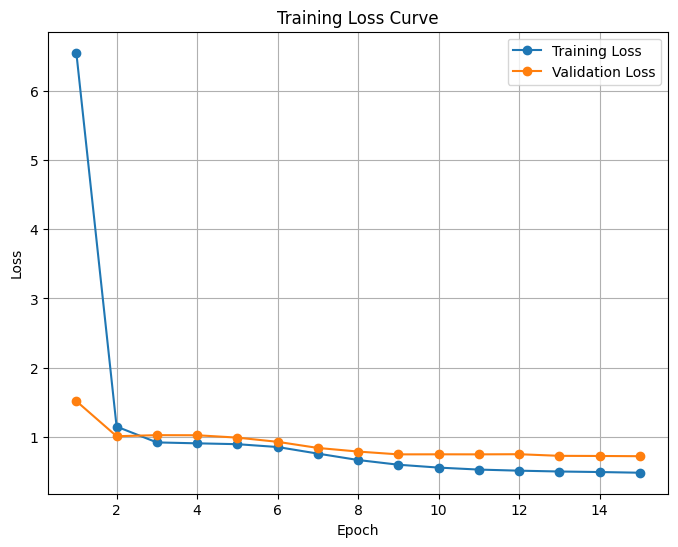

In [19]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))
plt.plot(range(1, len(losses_train) + 1), losses_train, marker='o', label="Training Loss")
plt.plot(range(1, len(losses_val) + 1), losses_val, marker='o', label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training Loss Curve")
plt.legend()
plt.grid(True)
plt.show()

In [20]:
def compute_rmse(model, loader):
    model.eval()
    total_loss = 0.0
    with torch.no_grad():
        for user, item, rating in loader:
            user, item, rating = user.to(device), item.to(device), rating.to(device)
            pred = model(user, item)
            total_loss += nn.MSELoss(reduction='sum')(pred, rating).item()
    mse = total_loss / len(loader.dataset)
    return torch.sqrt(torch.tensor(mse)).item()

train_rmse = compute_rmse(model, train_loader)
val_rmse = compute_rmse(model, val_loader)

print(f"Train RMSE: {train_rmse:.4f}")
print(f"Validation RMSE: {val_rmse:.4f}")

Train RMSE: 0.6312
Validation RMSE: 0.8504


# Using the validation set to test the evaluate.py function

In [21]:
df_valid = pd.read_csv("data/validation.csv")
df_valid

,ReviewerID,ProductID,Star
0,A25X28UZCW2J6G,B00K9V6B94,4.0
1,A1FUH1O6FCTUYG,B00GZANS6M,5.0
2,AAUVEEG5YLZAX,B01864DDVO,5.0
3,A3VQLGTYTL5196,B001BXNQ2O,5.0
4,A10JAUCIGVRW9F,B0116MZUS2,5.0
...,...,...,...
6591,A3TC60MGLW1I76,B00EHSUFD8,4.0
6592,AGE0YGLF7L2ZL,B014LQ18CW,4.0
6593,AT2ZB20OCU7X2,B00ZRDPPU0,4.0
6594,A1ACUN6A2LYVMW,B01EKIELGG,1.0


In [22]:
valid_dataset = RatingDataset(df_valid,reviewer_map,product_map)
valid_dataloader = DataLoader(valid_dataset,batch_size=1,shuffle=False)

star = []

model.eval()
with torch.no_grad():
    for reviewer, product, _ in valid_dataloader:
            reviewer,product = reviewer.to(device), product.to(device)
            predict = model(reviewer,product)
            star.append(predict.item())

df_valid['Star'] = star        

In [23]:
df_valid

,ReviewerID,ProductID,Star
0,A25X28UZCW2J6G,B00K9V6B94,3.639065
1,A1FUH1O6FCTUYG,B00GZANS6M,4.472114
2,AAUVEEG5YLZAX,B01864DDVO,4.200575
3,A3VQLGTYTL5196,B001BXNQ2O,4.645829
4,A10JAUCIGVRW9F,B0116MZUS2,4.771163
...,...,...,...
6591,A3TC60MGLW1I76,B00EHSUFD8,3.181931
6592,AGE0YGLF7L2ZL,B014LQ18CW,4.458926
6593,AT2ZB20OCU7X2,B00ZRDPPU0,4.709325
6594,A1ACUN6A2LYVMW,B01EKIELGG,3.879048


In [24]:
df_valid.to_csv('validation_prediction.csv',index=False)

In [25]:
from evaluate import rmse

val_df = pd.read_csv("data/validation.csv")

pred_df = pd.read_csv("validation_prediction.csv")

df = pd.merge(
    val_df,
    pred_df,
    how="left",
    left_on=["ReviewerID", "ProductID"],
    right_on=["ReviewerID", "ProductID"],
)
print(df.shape)
df.fillna(0, inplace=True)
df.head()

print("VALIDATION RMSE: ", rmse(df["Star_y"].values, df["Star_x"].values))

(6596, 4)
VALIDATION RMSE:  0.8504172377512874


In [26]:
df

,ReviewerID,ProductID,Star_x,Star_y
0,A25X28UZCW2J6G,B00K9V6B94,4.0,3.639065
1,A1FUH1O6FCTUYG,B00GZANS6M,5.0,4.472114
2,AAUVEEG5YLZAX,B01864DDVO,5.0,4.200575
3,A3VQLGTYTL5196,B001BXNQ2O,5.0,4.645829
4,A10JAUCIGVRW9F,B0116MZUS2,5.0,4.771163
...,...,...,...,...
6591,A3TC60MGLW1I76,B00EHSUFD8,4.0,3.181931
6592,AGE0YGLF7L2ZL,B014LQ18CW,4.0,4.458926
6593,AT2ZB20OCU7X2,B00ZRDPPU0,4.0,4.709325
6594,A1ACUN6A2LYVMW,B01EKIELGG,1.0,3.879048


# Predict on testing set

In [27]:
df_test = pd.read_csv("data/prediction.csv")
df_test

,ReviewerID,ProductID,Star
0,A2MK1L1Y74WTWH,B01GT5XDFS,0
1,A19I68RW4PBT29,B00OME9OQQ,0
2,A1UPHTDW5GM12T,B01GSRNLOK,0
3,A1LFIFPYMOJ8RV,B01CUJYMR0,0
4,A10Y597K071WTQ,B004SI455Q,0
...,...,...,...
6628,A23Y4UGTFDMZOP,B00J5327X6,0
6629,A2PFNDDKHOOMZU,B01G0GIXJ2,0
6630,A1K4S4MWXI9E9M,B01FKDKB96,0
6631,AOLHNMI8G8R6K,B00NUDPR66,0


In [28]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6633 entries, 0 to 6632
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   ReviewerID  6633 non-null   object
 1   ProductID   6633 non-null   object
 2   Star        6633 non-null   int64 
dtypes: int64(1), object(2)
memory usage: 155.6+ KB


In [29]:
test_dataset = RatingDataset(df_test,reviewer_map,product_map)
test_dataloader = DataLoader(test_dataset,batch_size=1,shuffle=False)

pred_star = []

model.eval()
with torch.no_grad():
    for reviewer, product, _ in test_dataloader:
            reviewer,product = reviewer.to(device), product.to(device)
            predict = model(reviewer,product)
            pred_star.append(predict.item())

df_test['Star'] = pred_star

In [30]:
df_test

,ReviewerID,ProductID,Star
0,A2MK1L1Y74WTWH,B01GT5XDFS,3.617380
1,A19I68RW4PBT29,B00OME9OQQ,4.811192
2,A1UPHTDW5GM12T,B01GSRNLOK,4.785728
3,A1LFIFPYMOJ8RV,B01CUJYMR0,4.723450
4,A10Y597K071WTQ,B004SI455Q,4.849006
...,...,...,...
6628,A23Y4UGTFDMZOP,B00J5327X6,3.934829
6629,A2PFNDDKHOOMZU,B01G0GIXJ2,4.172071
6630,A1K4S4MWXI9E9M,B01FKDKB96,3.760166
6631,AOLHNMI8G8R6K,B00NUDPR66,4.814306


In [31]:
df_test.to_csv('./prediction.csv',index=False)